# AdaptiveIS-CE-fitGaussian.ipynb
Adaptive Importance Sampling / Cross-Entropy updates for matching a Gaussian target.

Target distribution: $p(x) = \mathcal{N}(2, 0.75^2)$.
Proposal family: $q_\theta(x) = \mathcal{N}(\mu, \sigma^2)$.

We start from a broad, misaligned proposal and iteratively update $(\mu,\sigma)$
via weighted maximum-likelihood (equivalently, minimizing KL$(p\|q_\theta)$ in this 1D setting).

Initial (mu, sigma) = (0.0, 3.0)
Final (mu, sigma)   = (2.0072232961770853, 0.7550954172418782)
True target (mean, sd) = (2.0, 0.75)
ESS per iteration: [1082.2162887312115, 2186.9919348763283, 3236.3007298742154, 3839.8086316279823, 3982.9587477272835, 3996.443169438218, 3998.5550253306064, 3999.722130948318]
Saved figure to figs/CE_fitGaussian_panels.png


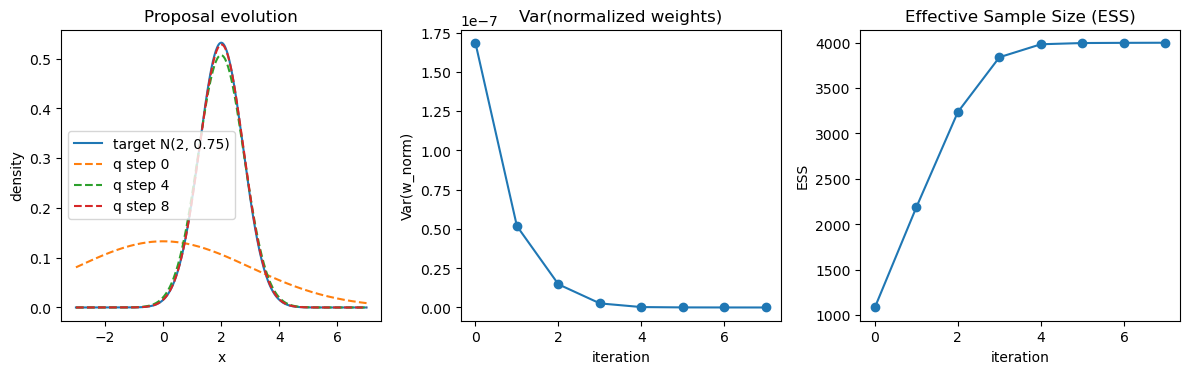

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import os, math

# Ensure figs directory exists
os.makedirs("figs", exist_ok=True)

# Target: N(2, 0.75^2)
target_mean = 2.0
target_sd = 0.75
target = norm(loc=target_mean, scale=target_sd)

# AIS / CE parameters
mu0 = 0.0       # very poor initial guess
sigma0 = 3.0    # very broad initial proposal
N = 4000        # samples per iteration
num_iter = 8    # number of adaptation steps
alpha = 0.7     # smoothing factor
sigma_floor = 0.2

mus = [mu0]
sigmas = [sigma0]
ess_list = []
weight_vars = []

rng = np.random.default_rng(123)

for t in range(num_iter):
    mu_t = mus[-1]
    sigma_t = sigmas[-1]
    proposal = norm(loc=mu_t, scale=sigma_t)
    
    # Sample from current proposal
    x = proposal.rvs(size=N, random_state=rng)
    
    # Importance weights w = p(x)/q(x)
    w = target.pdf(x) / proposal.pdf(x)
    w_norm = w / np.sum(w)
    
    # Diagnostics
    ess = 1.0 / np.sum(w_norm**2)
    ess_list.append(ess)
    weight_vars.append(np.var(w_norm))
    
    # Weighted MLE update for mean and variance (CE step)
    mu_w = np.sum(w_norm * x)
    var_w = np.sum(w_norm * (x - mu_w)**2)
    
    new_mu = alpha * mu_w + (1.0 - alpha) * mu_t
    new_sigma = math.sqrt(alpha * var_w + (1.0 - alpha) * (sigma_t**2))
    new_sigma = max(new_sigma, sigma_floor)
    
    mus.append(new_mu)
    sigmas.append(new_sigma)

print("Initial (mu, sigma) =", (mu0, sigma0))
print("Final (mu, sigma)   =", (mus[-1], sigmas[-1]))
print("True target (mean, sd) =", (target_mean, target_sd))
print("ESS per iteration:", ess_list)

# Build diagnostics figure
xs = np.linspace(-3, 7, 400)

plt.figure(figsize=(12, 4))

# Panel 1: evolution of proposal densities vs target
plt.subplot(1, 3, 1)
plt.plot(xs, target.pdf(xs), label="target N(2, 0.75)")
indices_to_plot = [0, num_iter//2, num_iter]
for idx in indices_to_plot:
    mu_p = mus[idx]
    sigma_p = sigmas[idx]
    proposal_p = norm(loc=mu_p, scale=sigma_p)
    plt.plot(xs, proposal_p.pdf(xs), linestyle="--", label=f"q step {idx}")
plt.title("Proposal evolution")
plt.xlabel("x")
plt.ylabel("density")
plt.legend()

# Panel 2: variance of normalized weights
plt.subplot(1, 3, 2)
plt.plot(range(num_iter), weight_vars, marker="o")
plt.title("Var(normalized weights)")
plt.xlabel("iteration")
plt.ylabel("Var(w_norm)")

# Panel 3: ESS over iterations
plt.subplot(1, 3, 3)
plt.plot(range(num_iter), ess_list, marker="o")
plt.title("Effective Sample Size (ESS)")
plt.xlabel("iteration")
plt.ylabel("ESS")

plt.tight_layout()
savepath = "figs/CE_fitGaussian_panels.png"
plt.savefig(savepath, dpi=150, bbox_inches="tight")
print(f"Saved figure to {savepath}")
plt.show()